In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
data_dir = '/nfs/turbo/si-juliame/metaphor/results/full_datasheets/2024-10-07/'
res_dir = '/nfs/turbo/si-juliame/metaphor/results/regression/metaphor_effects/'
plots_dir = '/home/juliame/metaphor/results/plots_feb2025/'
tables_dir = '/home/juliame/metaphor/results/tables_feb2025/'

In [4]:
# Get original dataframes to calculate original means 
df_orig = pd.read_csv(os.path.join(data_dir,'filtered_tweet_data_shuffled_no_text_results_with_scores.tsv'),sep='\t')
df_orig['ideology'] = df_orig['ideology'].apply(lambda x: 1 if x > 0 else 0)


In [5]:
# How many tweets have non-zero favorites and retweets in this dataset? 
engagement_stats = {}
engagement_stats['has_favorite_num'] = len(df_orig[df_orig['log_favorites']>0])
engagement_stats['has_retweet_num'] = len(df_orig[df_orig['log_retweets']>0])
engagement_stats['has_favorite_freq'] = engagement_stats['has_favorite_num'] / len(df_orig)
engagement_stats['has_retweet_freq'] = engagement_stats['has_retweet_num'] / len(df_orig)
engagement_stats

{'has_favorite_num': 153357,
 'has_retweet_num': 91885,
 'has_favorite_freq': 0.3833925,
 'has_retweet_freq': 0.2297125}

In [6]:
def create_file_prefix(includeFrames,includeIdeology,includeOverall,date):
    prefix = 'score_'
    if includeFrames:
        prefix += 'frames_'
    else:
        prefix += 'no_frames_'
    if includeOverall:
        prefix += 'with_overall_'
    if includeIdeology:
        prefix += 'with_ideology_'
    prefix += date
    prefix += '_'
    return prefix

In [7]:
def load_results(res_dir,date,includeFrames=False,includeIdeology=False,includeOverall = False):
    file_prefix = create_file_prefix(includeFrames,includeIdeology,includeOverall,date)
    df_reg = pd.read_csv(os.path.join(res_dir,file_prefix + 'regression_results.tsv'),sep='\t')
    df_mfx = pd.read_csv(os.path.join(res_dir,file_prefix + 'avg_marginal_effects.tsv'),sep='\t')
    df_mfx_group = None
    if includeIdeology:
        df_mfx_group = pd.read_csv(os.path.join(res_dir,file_prefix + 'marginal_effects_by_ideology.tsv'),sep='\t')
    return df_reg,df_mfx,df_mfx_group
    


In [8]:
def clean_results(df_old):
    df = df_old.copy()
    df = df.rename(columns={'term':'concept'})
    df['outcome'] = df['outcome'].replace({'log_favorites':'favorites','log_retweets':'retweets'})
    df['concept'] = df['concept'].str.replace('^score_', '', regex=True)
    if 'ideology' in df.columns:
        df['ideology'] = df['ideology'].replace({0:'Liberal',1:'Conservative'})
        return df[['concept','outcome','ideology','estimate','std.error']]
    return df[['concept','outcome','estimate','std.error']]

In [9]:
def back_transform(df_old):
    df = df_old.copy()
    df['log_change'] = df['estimate']
    df['log_change_4sd'] = 4 * df['log_change']
    df['percent_change'] = 100*(np.exp(df['log_change'])-1)
    df['percent_change_se'] = 100*df['std.error'] * np.exp(df['log_change']) # Delta Method
    df['percent_change_4sd'] = 100*(np.exp(df['log_change_4sd'])-1)
    df['percent_change_se_4sd'] = 100*4*df['std.error'] * np.exp(df['log_change_4sd']) # Delta Method
    return df

In [138]:
def plot_mfx_overall(df_full,outcome,estimate_col,error_col,annot_bars=True,shading=True):
    df = df_full[df_full['outcome']==outcome]
    concept_order = df.sort_values(by=estimate_col,ascending=False)['concept']
    color = sns.color_palette('colorblind')[2]
    g = sns.catplot(y='concept',x=estimate_col,data=df,kind='bar',color=color,height=3,aspect=1.24,order=concept_order)
    ax = g.axes[0,0]
    if annot_bars:
        for container in g.ax.containers:
            g.ax.bar_label(container, fmt='%.2f', padding=-30,color='black',fontsize=8)
    ax.axvline(x=0,color='black',alpha=.3)
    ax.errorbar(y = df['concept'],x = df[estimate_col], xerr = 1.96 * df[error_col],fmt='none',c='black')
    ax.set_xlabel(f'Marginal Effect on {outcome.title()}',fontsize='10')
    ax.set_ylabel('')
    ax.set_ylim((6.5,-.5))
    # plt.yticks(fontsize='12')
    if shading:
        for i in range(0,8,2):
            ax.axhspan(i-.5,i+.5,facecolor='gray',alpha=0.1,clip_on=False)


In [186]:
def plot_mfx_by_ideology(df_full,outcome,estimate_col,error_col,include_error=True,shading=True):
    df = df_full[df_full['outcome']==outcome]
    concept_order = df[df['ideology']=='Liberal'].sort_values(by=estimate_col,ascending=False)['concept']
    
    color1 = sns.color_palette('colorblind')[0]
    color2 = sns.color_palette('colorblind')[3]
    colors = [color1,color2] * len(concept_order)
    markers = ['o', 'p']  # Circle and square
    
    fig, ax = plt.subplots(figsize=(3,3))
    sns.pointplot(x=estimate_col,y='concept',hue='ideology',data=df,order=concept_order,markers=markers,
                   palette=colors,linestyle='none',dodge=0.4,ax=ax)
    sns.despine()
    ax.axvline(x=0,color='black',alpha=.3)
    ax.set_xlabel(f'Marginal Effect on {outcome.title()}')
    ax.set_ylabel('')
    ax.set_ylim((6.5,-.5))
    plt.legend(loc='upper center',bbox_to_anchor=(.45,1.15),ncol=2)



    if include_error:
        err_pos = sorted([i - 0.2 for i in range(int(len(df)/2))] + [i+0.2 for i in range(int(len(df)/2))])
        errors = []
        estimates = []
        for concept in concept_order:
            errors += list(df.loc[(df['concept']==concept)]
                           .sort_values('ideology',ascending=False)[error_col])
            estimates += list(df.loc[(df['concept']==concept)]
                              .sort_values('ideology',ascending=False)[estimate_col])
        errors = [i*1.96 for i in errors]
        for pos,estimate,err,color in zip(err_pos,estimates,errors,colors):
            ax.errorbar(x=estimate,y=pos,xerr=err,fmt='none', color=color)    

    if shading:
        for i in range(0,8,2):
            ax.axhspan(i-.5,i+.5,facecolor='gray',alpha=0.1,clip_on=False)
       

In [12]:
includeFrames=False # True or False, depending on if we want results from regression controlling for issue-generic policy frames
outcome = 'retweets' #retweets or favorites


frame_prefix = 'no_frames'
if includeFrames:
    frame_prefix='with_frames'
    
includeIdeology = True #Always True. ideology was controlled in all final models
includeOverall = False #Always False, we're looking at by-concept variation.
date = '2024-10-07' #File structure includes this date (same for all final models)
df_reg,df_mfx,df_mfx_group = load_results(res_dir,date,includeFrames,includeIdeology,includeOverall)

df_mfx = clean_results(df_mfx)
df_mfx = back_transform(df_mfx)
df_mfx.to_csv(os.path.join(tables_dir,f'mfx_engagement_{frame_prefix}.tsv'),sep='\t')

df_mfx_group = clean_results(df_mfx_group)
df_mfx_group = back_transform(df_mfx_group)
df_mfx_group.to_csv(os.path.join(tables_dir,f'mfx_engagement_by_ideology_{frame_prefix}.tsv'),sep='\t')

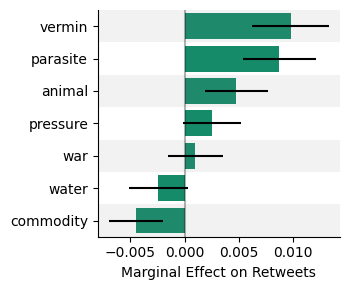

In [252]:
estimate = 'estimate'
error = 'std.error'
plot_mfx_overall(df_mfx,outcome,estimate,error,annot_bars=False)
outfile = os.path.join(plots_dir,f'marginal_effects_on_{outcome}_{estimate}_{frame_prefix}.pdf')
plt.savefig(outfile,bbox_inches='tight')

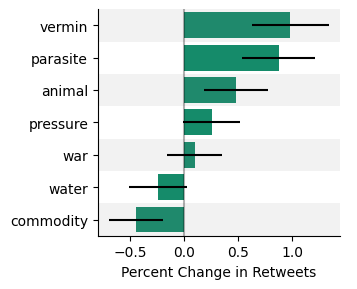

In [253]:
estimate = 'percent_change'
error = 'percent_change_se'
plot_mfx_overall(df_mfx,outcome,estimate,error,annot_bars=False)
plt.xlabel(f'Percent Change in {outcome.title()}') 
outfile = os.path.join(plots_dir,f'marginal_effects_on_{outcome}_{estimate}_{frame_prefix}.pdf')
plt.savefig(outfile,bbox_inches='tight')

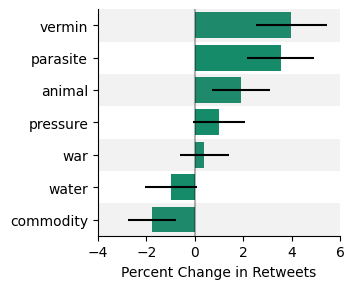

In [255]:
estimate = 'percent_change_4sd'
error = 'percent_change_se_4sd'
plot_mfx_overall(df_mfx,outcome,estimate,error,annot_bars=False)
plt.xlabel(f'Percent Change in {outcome.title()}') 
plt.xticks(np.arange(start=-4, stop=7, step=2))

outfile = os.path.join(plots_dir,f'marginal_effects_on_{outcome}_{estimate}_{frame_prefix}.pdf')
plt.savefig(outfile,bbox_inches='tight')

/tmp/ipykernel_3489482/3480775587.py:11: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.pointplot(x=estimate_col,y='concept',hue='ideology',data=df,order=concept_order,markers=markers,


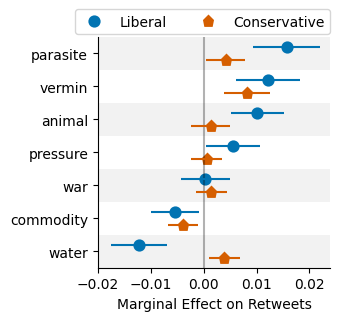

In [257]:
estimate = 'estimate'
error = 'std.error'

plot_mfx_by_ideology(df_mfx_group,outcome,estimate,error)
plt.xlabel(f'Marginal Effect on {outcome.title()}')
plt.xticks(np.arange(start=-.02, stop=.03, step=.01))


outfile = os.path.join(plots_dir,f'marginal_effects_on_{outcome}_{estimate}_{frame_prefix}_by_ideology.pdf')
plt.savefig(outfile,bbox_inches='tight')

/tmp/ipykernel_3489482/3480775587.py:11: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.pointplot(x=estimate_col,y='concept',hue='ideology',data=df,order=concept_order,markers=markers,


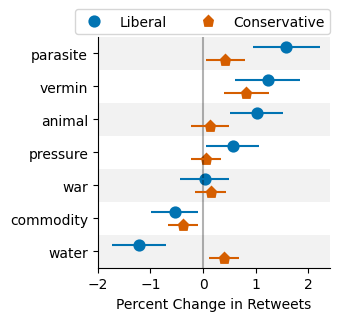

In [259]:
estimate = 'percent_change'
error = 'percent_change_se'

plot_mfx_by_ideology(df_mfx_group,outcome,estimate,error)
plt.xlabel(f'Percent Change in {outcome.title()}')
plt.xticks(np.arange(start=-2, stop=3, step=1))


outfile = os.path.join(plots_dir,f'marginal_effects_on_{outcome}_{estimate}_{frame_prefix}_by_ideology.pdf')
plt.savefig(outfile,bbox_inches='tight')

/tmp/ipykernel_3489482/3480775587.py:11: UserWarning: The palette list has more values (14) than needed (2), which may not be intended.
  sns.pointplot(x=estimate_col,y='concept',hue='ideology',data=df,order=concept_order,markers=markers,


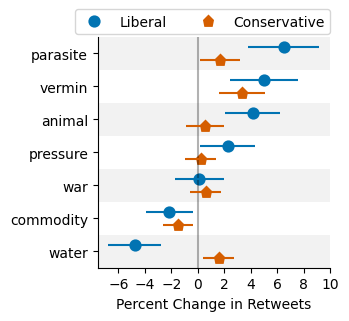

In [261]:
estimate = 'percent_change_4sd'
error = 'percent_change_se_4sd'

plot_mfx_by_ideology(df_mfx_group,outcome,estimate,error)
plt.xlabel(f'Percent Change in {outcome.title()}')
plt.xticks(np.arange(start=-6, stop=10.1, step=2))


outfile = os.path.join(plots_dir,f'marginal_effects_on_{outcome}_{estimate}_{frame_prefix}_by_ideology.pdf')
plt.savefig(outfile,bbox_inches='tight')

In [264]:
df_mfx_group[df_mfx_group['outcome']=='retweets'].sort_values(
    by='percent_change_4sd',ascending=False)[['concept','ideology','percent_change_4sd']]

,concept,ideology,percent_change_4sd
19,parasite,Liberal,6.480148
23,vermin,Liberal,4.990859
15,animal,Liberal,4.127058
24,vermin,Conservative,3.331006
21,pressure,Liberal,2.257251
20,parasite,Conservative,1.681984
28,water,Conservative,1.583008
26,war,Conservative,0.575863
16,animal,Conservative,0.522021
22,pressure,Conservative,0.217218
